# TP1 - Museos y PageRank

## Grupo Moritas

### Integrantes:
- **Lucio Tag**  
  - Mail: [luciotag2011@gmail.com](mailto:luciotag2011@gmail.com)  
  - LU: 876/22
- **Matias Arazi**  
  - Mail: [matiasarazi@gmail.com](mailto:matiasarazi@gmail.com)  
  - LU: 1409/23
- **Gerson Paredes**  
  - Mail: [gerson.p.maldonado@gmail.com](mailto:gerson.p.maldonado@gmail.com)  
  - LU: 1865/21


In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
#import seaborn as sns # Para hacer plots lindos
# import networkx as nx # Construcción de la red en NetworkX
import scipy
from template_funciones_1 import construye_adyacencia, calculaLU, calcula_matriz_C, calcula_pagerank, calcula_matriz_C_continua, calcula_B

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<AxesSubplot: >

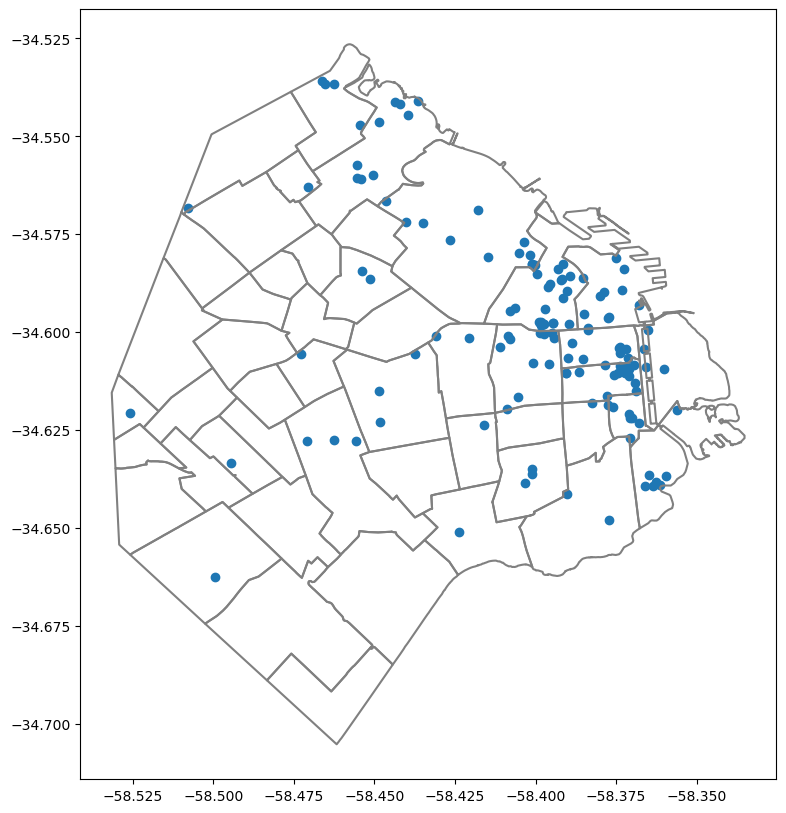

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [ ]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

AttributeError: module 'numpy' has no attribute 'from_numpy_array'

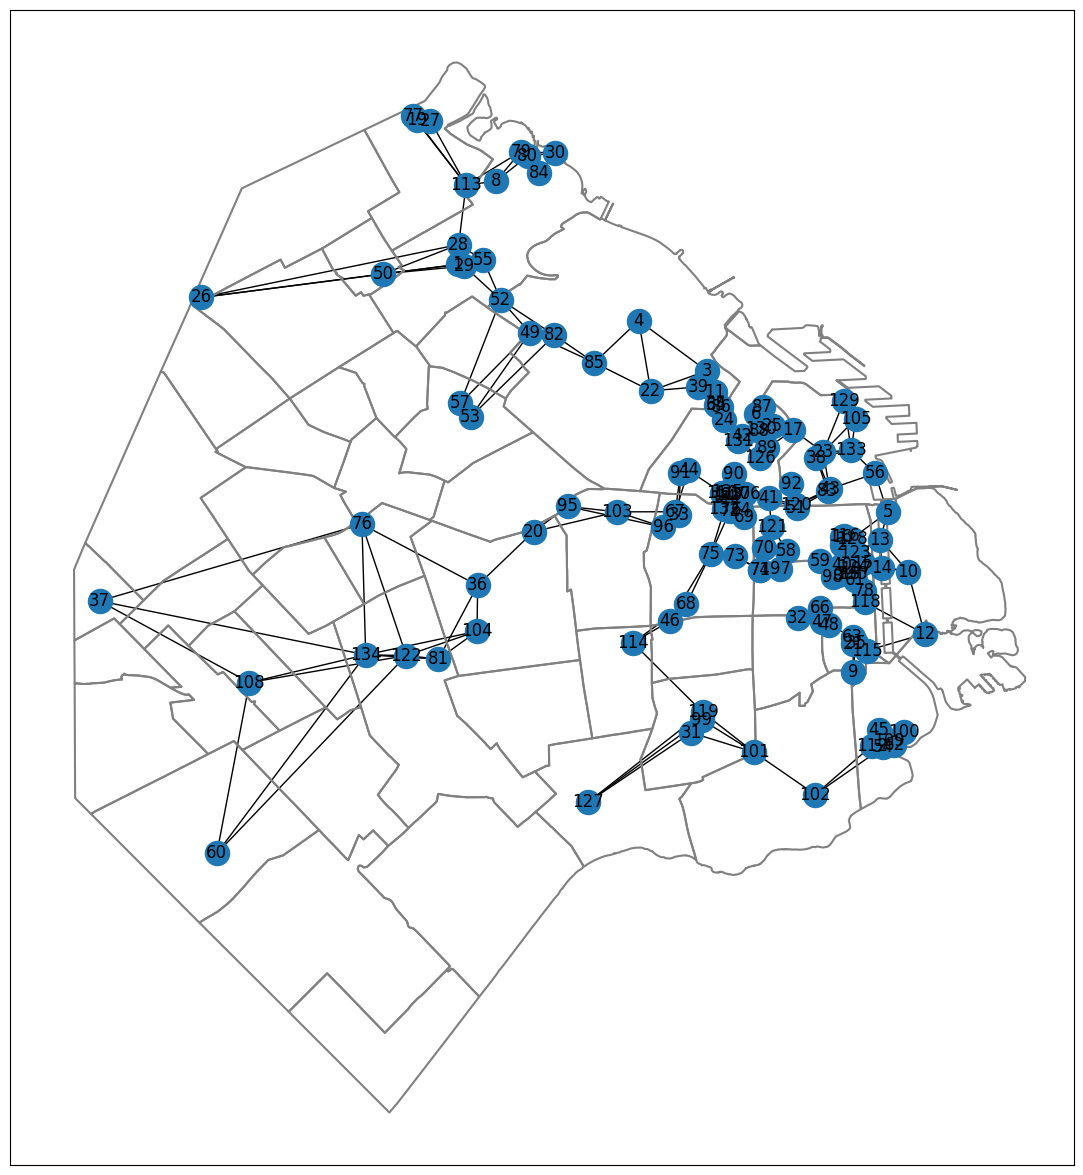

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

\begin{align}
p &= (1 - \alpha) C p + \frac{\alpha}{N} \mathbf{1} \\
\end{align}

Pasando todos los términos con $p$ al lado izquierdo:
\begin{align}
p - (1 - \alpha) C p &= \frac{\alpha}{N} \mathbf{1} \\
(I - (1 - \alpha)C) p &= \frac{\alpha}{N} \mathbf{1}
\end{align}

Multiplicando ambos lados por $\frac{N}{\alpha}$:
\begin{align}
\frac{N}{\alpha} (I - (1 - \alpha)C) p &= \mathbf{1}
\end{align}

Si definimos $M = \frac{N}{\alpha} (I - (1 - \alpha)C)$ y $b = \mathbf{1}$, entonces tenemos:
\begin{align}
M p &= b
\end{align}


Por lo tanto, queda demostrado que el vector de rankings $p$ es la solución del sistema de ecuaciones $Mp = b$ con los valores establecidos para $M$ y $b$.

## Punto 2:



\begin{align}
\text{Demostración de que $M$ es inversible cuando $0 < \alpha < 1$}
\end{align}

Recordemos que $M = \frac{N}{\alpha}(I - (1-\alpha)C)$. Para que $M$ sea inversible, basta con demostrar que $(I - (1-\alpha)C)$ es inversible, ya que $\frac{N}{\alpha}$ es un escalar positivo.

Vamos a demostrar que $(I - (1-\alpha)C)$ es inversible cuando $0 < \alpha < 1$ y $C$ es una matriz estocástica por columnas (es decir, cada columna suma 1).

**Definiciones:**

- $\|B\|_1$: norma 1 matricial de $B$, definida como el máximo de las sumas de los valores absolutos por columna  
- $C$: matriz estocástica por columnas (cada columna suma 1)  
- $\alpha$: escalar tal que $0 < \alpha < 1$  
- $B = (1 - \alpha)C$

Queremos demostrar que:

$$
(1)\quad \text{Si } \|B\|_1 < 1, \text{ entonces } I - B \text{ es invertible}
$$

### Desarrollo:

1. Por definición de norma 1 matricial:

$$
\|B\|_1 = \max_{1 \leq j \leq n} \sum_{i=1}^{n} |b_{ij}|
$$

   Si $C$ es estocástica por columnas, entonces $\|C\|_1 = 1$.  
   Como $B = (1 - \alpha)C$ con $0 < \alpha < 1$, se deduce que:

   $$
   \|B\|_1 = (1 - \alpha)\|C\|_1 = (1 - \alpha) < 1 \Rightarrow \|B\|_1 < 1
   $$

2. Recordamos una propiedad clave de la norma 1:

$$
\|Bv\|_1 \leq \|B\|_1 \|v\|_1 \quad \text{para cualquier vector } v
$$

3. Supongamos que $I - B$ **no es invertible**.  
   Entonces existe $v \neq 0$ tal que:

$$
(I - B)v = 0 \quad \Rightarrow \quad v = Bv
$$

   Aplicando la norma 1 a ambos lados:

   $$
   \|v\|_1 = \|Bv\|_1 \leq \|B\|_1 \|v\|_1
   $$

4. Como $v \neq 0$, se cumple que $\|v\|_1 > 0$ y entonces:

$$
1 \leq \|B\|_1
$$

* Esto contradice la hipótesis inicial de que $\|B\|_1 < 1$

5. Por lo tanto, la suposición de que $I - B$ no es invertible lleva a una contradicción.

$$
\therefore I - B \text{ es invertible, es decir, } \boxed{ I-(1- \alpha)C \text{ es invertible} }
$$

## Punto 3:

In [ ]:
## Luego de calcular y correr los codigos de: calculaLU, calcula_matriz_C, calcula_pagerank, visualizamos y calculamos lo pedido:
def visualizar(A, p, titulo, ax=None, mostrar_top3=True):
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt
    from textwrap import wrap

    G = nx.from_numpy_array(A)
    coords = museos.to_crs("EPSG:22184").get_coordinates()
    G_layout = {i: v for i, v in enumerate(zip(coords['x'], coords['y']))}

    escala = 500
    tamaños = escala * (p / np.max(p))

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))

    ax.set_facecolor('#fefefe')
    barrios.to_crs("EPSG:22184").boundary.plot(color='#d6d6d6', ax=ax, linewidth=0.5)

    color_nodo = "#F5EE9E"
    color_top1 = '#246EB9'
    color_top2 = '#F06543'
    color_top3 = '#4CB944'
    colores_top3 = [color_top1, color_top2, color_top3]

    top3_idx = np.argsort(-p)[:3]
    otros_idx = [i for i in range(len(p)) if i not in top3_idx]

    nx.draw_networkx_nodes(G, G_layout, ax=ax,
                           nodelist=otros_idx,
                           node_size=tamaños[otros_idx],
                           node_color=[color_nodo] * len(otros_idx),
                           alpha=0.55)

    nx.draw_networkx_nodes(G, G_layout, ax=ax,
                           nodelist=top3_idx,
                           node_size=tamaños[top3_idx],
                           node_color=colores_top3,
                           alpha=0.7)

    nx.draw_networkx_edges(G, G_layout, ax=ax, edge_color='#aaaaaa', alpha=1, width=0.4)

    ax.set_title(titulo, fontsize=12, weight='bold', color='#333333', loc='center')
    ax.axis('off')

    if mostrar_top3:
        # Layout de la caja Top 3
        x_box = ax.get_xlim()[1]
        width_box = 7000
        height_block = 2000
        spacing = 300
        y_start = ax.get_ylim()[1] - 500
        total_height = len(top3_idx) * height_block + (len(top3_idx) - 1) * spacing

        ax.add_patch(mpatches.FancyBboxPatch(
            (x_box, y_start - total_height + 1000),
            width_box,
            total_height,
            boxstyle="round,pad=0.02",
            edgecolor='lightgray',
            facecolor='white',
            lw=1.5,
            zorder=1
        ))

        for i, idx in enumerate(top3_idx):
            color = colores_top3[i]
            nombre = museos.iloc[idx]['name']
            score = p[idx]
            x_node, y_node = G_layout[idx]

            y = y_start - i * (height_block + spacing)
            x_inner = x_box + 150

            square_size = 700
            ax.add_patch(mpatches.Rectangle((x_inner, y - square_size // 2),
                                            square_size, square_size,
                                            facecolor=color, edgecolor='gray', lw=1.2))
            ax.text(x_inner + square_size / 2, y,
                    f"{i+1}°", ha='center', va='center',
                    fontsize=12, color='white', weight='bold', zorder=3)

            text_x = x_inner + square_size + 200
            wrapped_name = '\n'.join(wrap(nombre, width=30))

            ax.text(text_x, y - 100,
                    wrapped_name, fontsize=10, color='#333333', va='top', ha='left')

            ax.text(text_x, y + 100,
                    f"p = {score:.4f}", fontsize=10, color='dimgray', va='bottom', ha='left')

            ax.annotate("",
                        xy=(x_node, y_node),
                        xytext=(x_inner + square_size / 2, y),
                        arrowprops=dict(arrowstyle='-', color=color, lw=1.5, alpha=0.9),
                        zorder=0)

        ax.set_xlim(ax.get_xlim()[0], x_box + width_box + 800)


In [ ]:
# Funcion que resuelve el ejercicio 3 para cada m y alfa pedido
def ejercicio3(m, alfa, ax=None, mostrar_top3=True):
    # Primero construye la matriz de distancias D para el m pedido.
    A = construye_adyacencia(D, m)
    # Luego calculamos el p sobre ese m para el alfa pedido.
    p = calcula_pagerank(A, alfa)
    # Finalmente visualizamos la matriz de distancias y el grafo obtenido.
    visualizar(A, p, f"m={m}, α={alfa:.2f}", ax=ax, mostrar_top3=mostrar_top3)


### Resulevo ejercio 3

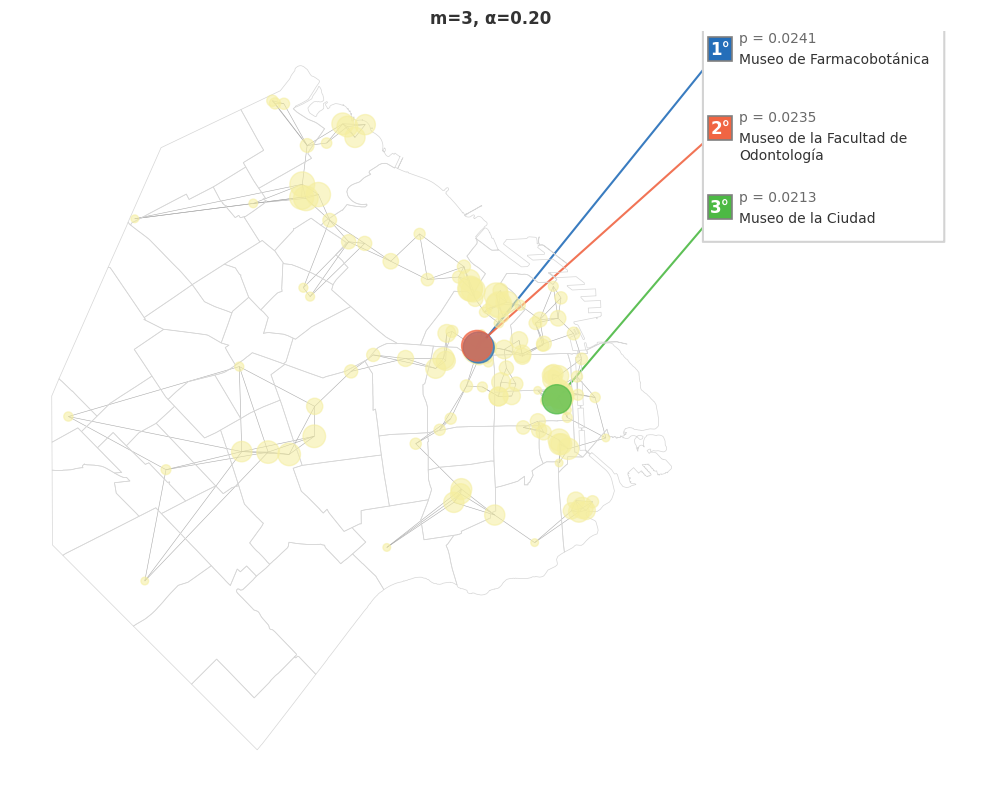

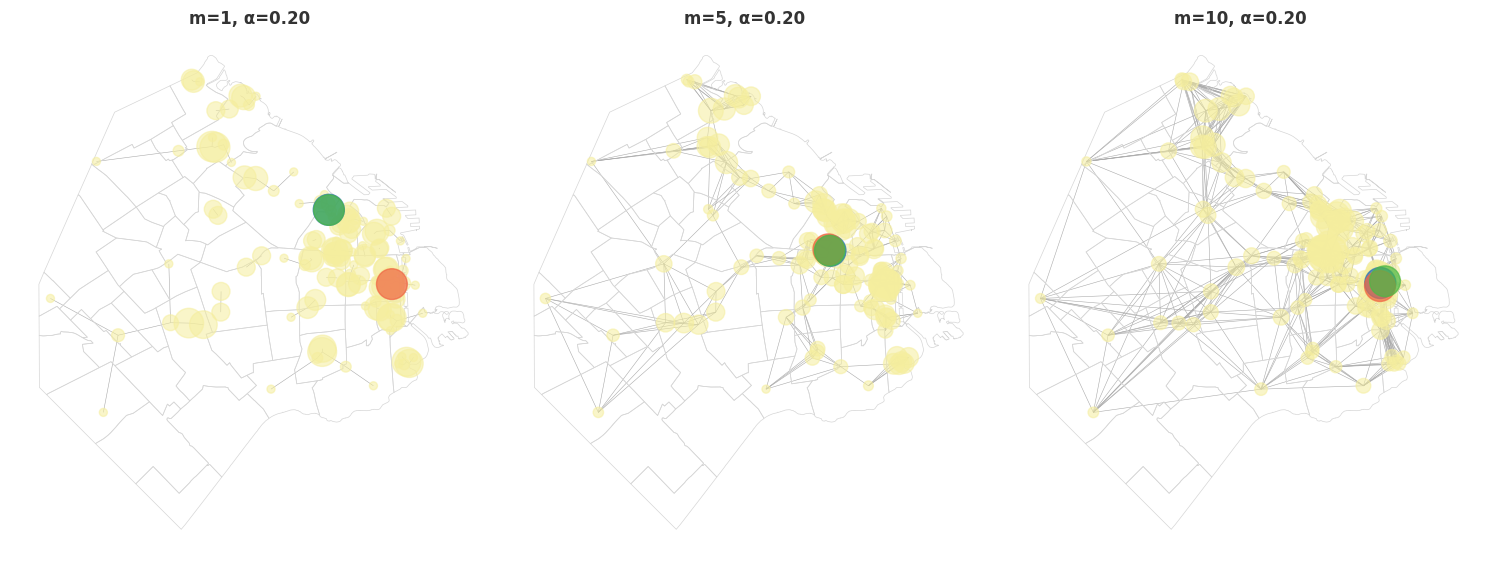

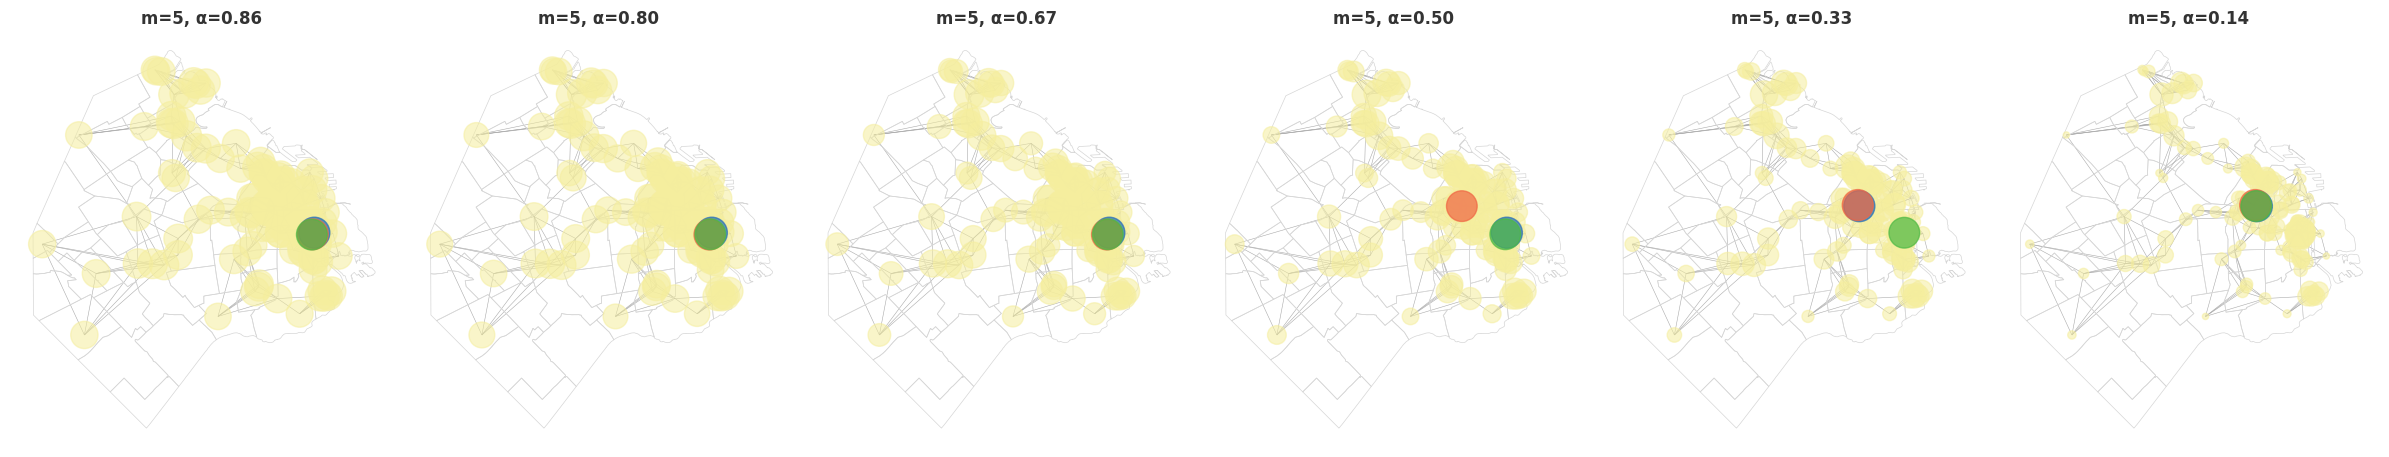

In [ ]:
# Caso especial: m=3 y alfa=1/5 con Top 3 visible y figura más grande
fig, ax = plt.subplots(figsize=(10, 8))
ejercicio3(3, 1/5, ax=ax, mostrar_top3=True)
plt.tight_layout()
plt.show()

# Visualizaciones de distintos valores de m (excepto m=3) con α fijo
ms = [1, 5, 10]  # excluimos m=3 porque ya lo mostramos arriba
alfa_fijo = 1/5

fig, axes = plt.subplots(1, len(ms), figsize=(5 * len(ms), 6))
for i, m in enumerate(ms):
    ejercicio3(m, alfa_fijo, ax=axes[i], mostrar_top3=False)
plt.tight_layout()
plt.show()

# Visualizaciones para diferentes valores de alfa (excepto alfa=1/5 que ya está en m=3)
alfas = [6/7, 4/5, 2/3, 1/2, 1/3, 1/7]  # excluimos 1/5
m_fijo = 5

fig, axes = plt.subplots(1, len(alfas), figsize=(4 * len(alfas), 6))
for i, alfa in enumerate(alfas):
    ejercicio3(m_fijo, alfa, ax=axes[i], mostrar_top3=False)
plt.tight_layout()
plt.show()




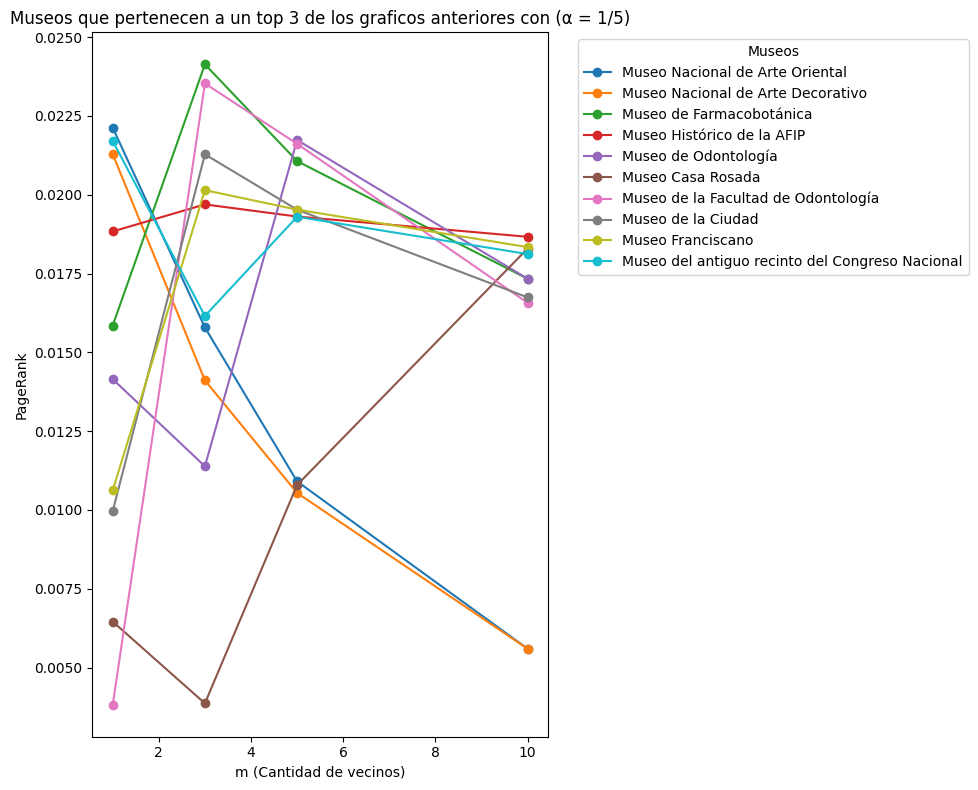

In [ ]:
# Graficamos a todos los museos y su variacion de pagerank a medida que cambia el m que pertenecen al top3 de mas PageRank
# En alguna de todas las combinaciones fijando el alfa en 1/5.
# Almacenar los resultados de PageRank por museo para cada valor de m
pagerank_por_museo = {name: [] for name in museos["name"]}

# Definir los valores de m
m_values = [1, 3, 5, 10]

# Lista para guardar todos los museos que estuvieron en el top 3 en al menos un m
museos_top3 = set()

# Calcular el PageRank para cada valor de m
for m in m_values:
    A = construye_adyacencia(D, m)
    p = calcula_pagerank(A, 1/5)  # alfa fijo en 1/5

    # Guardamos los PageRank
    for i, name in enumerate(museos["name"]):
        pagerank_por_museo[name].append(p[i])

    # Identificamos top 3 de este m y los agregamos al set
    top3_indices = np.argsort(p)[-3:][::-1]  # índices de los 3 más altos
    for idx in top3_indices:
        museos_top3.add(museos["name"][idx])

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar solo los museos que alguna vez estuvieron en el top 3
for name in museos_top3:
    ax.plot(m_values, pagerank_por_museo[name], label=name, marker='o')

# Añadir etiquetas y leyenda
ax.set_xlabel("m (Cantidad de vecinos)")
ax.set_ylabel("PageRank")
ax.set_title("Museos que pertenecen a un top 3 de los graficos anteriores con (α = 1/5)")
ax.legend(title="Museos", bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


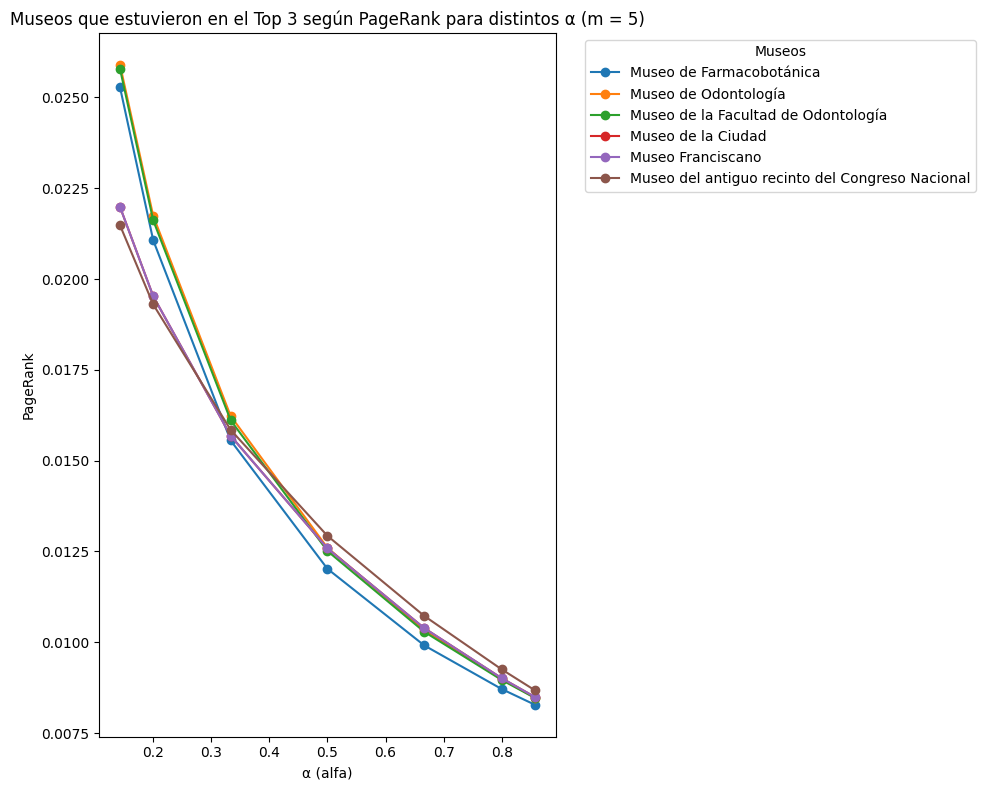

In [ ]:
# Graficamos a todos los museos y su variacion de pagerank a medida que cambia el alfa que pertenecen al top3 de mas PageRank
# En alguna de todas las combinaciones fijando el m en 5.
# Almacenar los resultados de PageRank por museo para cada valor de alfa
pagerank_por_museo_alfa = {name: [] for name in museos["name"]}

# Definir los valores de alfa
alfa_values = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]

# Fijamos m = 5 y construimos la matriz de adyacencia
m = 5
A = construye_adyacencia(D, m)

# Conjunto para guardar museos que estuvieron en el top 3 al menos una vez
museos_top3_alfa = set()

# Calcular el PageRank para cada valor de alfa
for alfa in alfa_values:
    p = calcula_pagerank(A, alfa)

    # Guardamos los PageRank
    for i, name in enumerate(museos["name"]):
        pagerank_por_museo_alfa[name].append(p[i])

    # Identificamos top 3 de este alfa y los guardamos
    top3_indices = np.argsort(p)[-3:][::-1]
    for idx in top3_indices:
        museos_top3_alfa.add(museos["name"][idx])

# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar solo los museos que estuvieron en el top 3 para algún alfa
for name in museos_top3_alfa:
    ax.plot(alfa_values, pagerank_por_museo_alfa[name], label=name, marker='o')

# Añadir etiquetas y leyenda
ax.set_xlabel("α (alfa)")
ax.set_ylabel("PageRank")
ax.set_title("Museos que estuvieron en el Top 3 según PageRank para distintos α (m = 5)")
ax.legend(title="Museos", bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()



### **Conclusiones ejercicio 3**
**¿Son estables las posiciones en el ranking? Describa los distintos patrones que observa, identificando qué ubicaciones son relevantes en cada caso. ¿Hay museos que solo son relevantes en redes con pocas conexiones? ¿Hay museos que se vuelven más relevantes mientras más conexiones aparecen?**

Las posiciones del ranking varían de forma notable según el valor de m, aunque ciertos museos tienden a destacarse consistentemente. Por ejemplo, el Museo Nacional de Arte Oriental y el Museo Nacional de Arte Decorativo solo figuran entre los primeros lugares cuando m es muy bajo, lo que indica que su relevancia depende de redes poco conectadas. En cambio, museos como el Museo de Odontología, el Museo Farmacobotánico y el Museo del antiguo recinto del Congreso Nacional aparecen repetidamente en los primeros puestos a medida que se incrementa m, lo que sugiere que ganan importancia en redes más densas. También se observa que algunos museos mantienen su centralidad más allá del valor de m, adaptándose bien tanto a estructuras locales como globales.

**¿Qué regiones se vuelven más predominantes al aumentar α? ¿Y al aumentar m?**

Cuando se aumenta m, se generan más conexiones entre los museos, incluso con los que están más lejos. Esto favorece especialmente a los que están ubicados en el centro de la ciudad, porque quedan más accesibles desde muchos otros puntos. Son como puntos de paso obligados dentro de la red. Por otro lado, si subimos el valor de α, el modelo le da más peso al azar, como si los visitantes eligieran los museos de forma más aleatoria. Esto hace que las diferencias entre los museos más populares y los menos visitados se achiquen. Aun así, hay museos como el del Congreso Nacional y el Museo de la Ciudad que siguen apareciendo entre los primeros, incluso cuando el recorrido es más aleatorio, lo que muestra que tienen un rol importante en casi cualquier escenario.



## Punto 4:

QVQ el vector de visitantes iniciales $v$ se puede estimar a partir del vector de visitas totales $w$ mediante la ecuación:
$$v = B^{-1} w, \quad \text{con} \quad B = \sum_{k=0}^{r-1} C^k$$

### Desarrollo

1.  **Distribución de visitantes en cada paso:**
    El vector de visitantes iniciales es $v^{(0)} = v$. El enunciado nos dice que si partimos de una distribución de visitantes $v$, después de $k$ pasos la nueva distribución esperada será $C^k v$.
    Esto se debe a que para obtener la distribución en el paso $k$, se debe aplicar la matriz de transición $C$ a la distribución del paso anterior, $v^{(k-1)}$. Así, se construye la secuencia de forma recursiva:
    -   Paso 0 (primera visita): $v^{(0)} = C^0 v = I v = v$
    -   Paso 1 (segunda visita): $v^{(1)} = C v^{(0)} = C v$
    -   Paso 2 (tercera visita): $v^{(2)} = C v^{(1)} = C(C v) = C^2 v$
    -   Paso 3 (cuarta visita): $v^{(3)} = C v^{(2)} = C(C^2 v) = C^3 v$
    -   Y asi sucesivamente, para el paso $k$: $v^{(k)} = C^k v$

2.  **Cálculo del total de visitas (w):**
    El vector de visitas totales $w$ es la suma de todas las distribuciones de visitantes a lo largo de las $r$ visitas que realiza cada persona. Esto es, la suma de las distribuciones desde el paso $k=0$ hasta el paso final $k=r-1$.
    $$w = v^{(0)} + v^{(1)} + v^{(2)} + \dots + v^{(r-1)}$$
    Sustituyendo las expresiones del punto anterior:
    $$w = \sum_{k=0}^{r-1} v^{(k)} = \sum_{k=0}^{r-1} C^k v$$

3.  **Despeje del vector de entrada (v):**
    Podemos sacar factor común $v$ de la sumatoria (ya que no depende del índice $k$):
    $$w = \left(\sum_{k=0}^{r-1} C^k\right) v$$
    Recordando la expresión entre paréntesis de la matriz $B$ definida en el enunciado:
    $$Bv = w$$
    Para despejar $v$, multiplicamos ambos lados de la ecuación por la inversa de $B$, $B^{-1}$ (asumiendo que $B$ es invertible, condición necesaria para que el problema tenga una única solución):
    $$B^{-1}w = B^{-1}Bv$$
    Dado que $B^{-1}B = I$ (la matriz identidad), la expresión se simplifica a:
    $$B^{-1}w = Iv$$
    Finalmente, obtenemos la relación buscada:
    $$v = B^{-1}w$$
    Con esto, queda demostrado que el vector de visitantes iniciales $v$ se puede calcular a partir del total de visitas $w$ y la matriz $B$.

## Punto 5:

In [ ]:
# (1)Construya una funcion calcula matriz C continua que reciba la matriz de distancias entre
# museos D y retorne la matriz C definida en la Eq. 4. (con def calcula_matriz_C_continua(D))

# (2)Construya una funcion calcula B(C,r) que reciba la matriz C y el numero de
# pasos r como argumento, y retorne la matriz B de la Eq. 5. (con def calcula_B(C,r))


# (3)Utilice la funcion calculaLU para resolver la Eq. 5. (con def calculaLU(matriz))

C = calcula_matriz_C_continua(D)
# Con la Eq. 5, construimos la matriz B con r=3
r = 3
B = calcula_B(C, r)
w = np.loadtxt('visitas.txt')

# Con LU, resolvemos Bv=w
L, U = calculaLU(B)
y = scipy.linalg.solve_triangular(L, w, lower=True)
v = scipy.linalg.solve_triangular(U, y)

# Calculamos la norma 1 de v, obteniendo finalmente la cantidad de personas que estimamos que entraron a la red
def norma1(matriz):
    # Calculamos la suma absoluta de cada columna
    ColSum = np.sum(np.abs(matriz), axis=0)
    # Agarramos el maximo de estas sumas
    maximasuma = np.max(ColSum)

    return maximasuma

total_visitantes = norma1(v)

print("Cantidad total estimada de personas que entraron a la red:", total_visitantes)

Cantidad total estimada de personas que entraron a la red: 136605.0


## Punto 6:

Para calcular $\text{Cond}_1(B)$ lo igualamos a $\|B\|_1 \cdot \|B^{-1}\|_1$.  
Primero calculamos $B$ con $r = 3$.

Luego, al saber que w tiene un margen de error del 5% concluimos que  $$\frac{\|w - \tilde{w}\|_1}{\|w\|_1} =  0,05$$

Entonces la ecuacion quedaria:

$$
\frac{\|v - \tilde{v}\|_1}{\|v\|_1} \leq \text{Cond}_1(B) \cdot \left(\frac{\|w - \tilde{w}\|_1}{\|w\|_1}\right) = \text{Cond}_1(B) \cdot 0{,}05 = (\|B\|_1 \cdot \|B^{-1}\|_1) \cdot 0{,}05
$$



In [ ]:
# Primero calculamos B con r=3
r=3
C = calcula_matriz_C_continua(D)
B = calcula_B(C, r)

# Luego calculamos la inversa de B
Binv = np.linalg.inv(B)

#> Ya escribieron esta funcion mas arriba!!! Las definiciones se mantienen entre celdas!
# Calculamos Norma 1 de B (con def norma1(B))

## Resolvemos la cuenta:
print("El numero de condicion de B es ", norma1(B)*norma1(Binv))
print("La cota para el error de estimacion de v es ", (norma1(B)*norma1(Binv))*0.05)


El numero de condicion de B es  5.051771176665004
La cota para el error de estimacion de v es  0.2525885588332502


### Conclusiones ejercicio 6
**Número de condición de** \( B \):

$$
\text{Cond}_1(B) \approx 5.05
$$

**Cota para el error relativo en la estimación de** \( v \):

$$
\left\| \frac{v - \tilde{v}}{v} \right\|_1 \leq 5.05 \cdot 0.05 = 0.2526
$$

El número de condición de la matriz \( B \) dio aproximadamente 5. Esto significa que si hay un error del 5% en los datos de visitas \( w \), el error en la estimación de \( v \) puede ser como máximo del 25%. Esa es la **cota del error**, es decir, el peor caso posible según las cuentas.


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

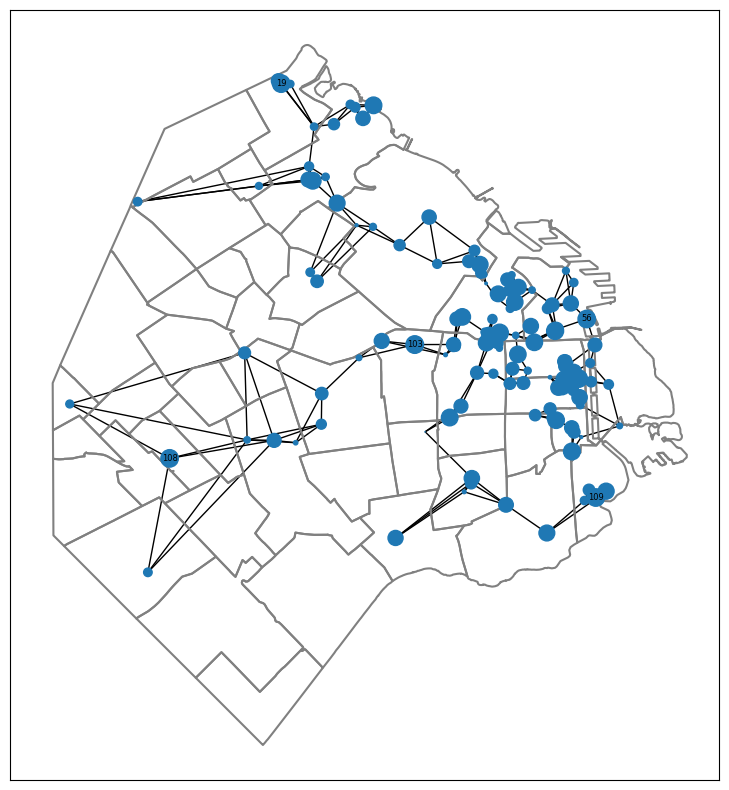

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

# TP2 - Detección de comunidades con métodos espectrales

In [6]:
from template_funciones_2 import calcula_L, calcula_R, calcula_lambda, calcula_Q, metpot1, deflaciona, metpot2, metpotI, metpotI2, laplaciano_iterativo, modularidad_iterativo

In [7]:
A_ejemplo = np.array([
   [0, 1, 1, 1, 0, 0, 0, 0],
   [1, 0, 1, 1, 0, 0, 0, 0],
   [1, 1, 0, 1, 0, 1, 0, 0],
   [1, 1, 1, 0, 1, 0, 0, 0],
   [0, 0, 0, 1, 0, 1, 1, 1],
   [0, 0, 1, 0, 1, 0, 1, 1],
   [0, 0, 0, 0, 1, 1, 0, 1],
   [0, 0, 0, 0, 1, 1, 1, 0]
])

## Punto 1:

### a)

* Matriz laplaciana: $L = K - A$, donde $K$ es la matriz diagonal de grados ($K_{ii} = k_i$), y $A$ es la matriz de adyacencia simétrica.
* Matriz de modularidad: $R = A - P$, con $P_{ij} = \frac{k_i k_j}{2E}$, siendo $k_i$ el grado del nodo $i$ y $E$ el número de aristas de la red.

Tenemos que demostrar que el vector de unos es autovector de las matrices Laplaciana $L$ y de modularidad $R$:

Sea $\mathbf{1}$ el vector columna de todos unos.

Entonces:

Para la Laplaciana:

$$
L\mathbf{1} = (K - A)\mathbf{1} = K\mathbf{1} - A\mathbf{1}
$$

Como $K$ es diagonal, $(K\mathbf{1})_i = k_i$ y $A$ es la matriz de adyacencia, $(A\mathbf{1})_i = \sum_{j=1}^N A_{ij} = k_i$.

Por lo tanto,

$$
(L\mathbf{1})_i = k_i - k_i = 0 \implies L\mathbf{1} = \mathbf{0}
$$

Es decir, $\mathbf{1}$ es autovector de $L$ con autovalor $0$.


Para la matriz de modularidad:

$$
R\mathbf{1} = (A - P)\mathbf{1} = A\mathbf{1} - P\mathbf{1}
$$

Nuevamente, $(A\mathbf{1})_i = k_i$.

Para el término $P$:

$$
(P\mathbf{1})_i = \sum_{j=1}^N P_{ij} = \sum_{j=1}^N \frac{k_i k_j}{2E} = k_i \left(\frac{1}{2E} \sum_{j=1}^N k_j \right)
$$

Como la suma de los grados en la red es $\sum_{j=1}^N k_j = 2E$:

$$
(P\mathbf{1})_i = k_i \cdot \frac{2E}{2E} = k_i
$$

Entonces,

$$
(R\mathbf{1})_i = k_i - k_i = 0 \implies R\mathbf{1} = \mathbf{0}
$$

Es decir, $\mathbf{1}$ es autovector de $R$ con autovalor $0$.

**Conclusión:**

El vector de unos $\mathbf{1}$ es autovector tanto de la matriz laplaciana $L$ como de la matriz de modularidad $R$, y en ambos casos su autovalor asociado es cero. Esto significa que, si consideramos la agrupación de la red definida por $\mathbf{1}$, estamos colocando a todos los nodos dentro de una única comunidad (es decir, no hay partición de la red).

En términos prácticos, esto implica que:

* Para la matriz laplaciana, el autovalor cero representa la situación en la que ningún enlace se corta porque todos los nodos están en el mismo grupo.
* Para la matriz de modularidad, el autovalor cero indica que no existe ganancia en modularidad respecto a una red aleatoria si no se realiza ninguna partición.

Por lo tanto, el vector de unos no identifica ninguna estructura de comunidades en la red, sino que simplemente agrupa a todos los nodos juntos. 

### b)

* $M$ es simétrica: $M = M^T$
* $M v_1 = \lambda_1 v_1$
* $M v_2 = \lambda_2 v_2$
* $\lambda_1 \ne \lambda_2$

Tomamos $v_1^T M v_2$ y lo calculamos de dos maneras:

**Por un lado:**

$$
v_1^T M v_2 = v_1^T (\lambda_2 v_2) = \lambda_2 (v_1^T v_2)
$$

**Por otro lado (usando la simetría de $M$):**

$$
v_1^T M v_2 = (M v_1)^T v_2 = (\lambda_1 v_1)^T v_2 = \lambda_1 (v_1^T v_2)
$$

**3. Igualando ambos resultados:**

$$
\lambda_2 (v_1^T v_2) = \lambda_1 (v_1^T v_2)
\implies
\lambda_2 (v_1^T v_2) - \lambda_1 (v_1^T v_2) = 0
\implies
(\lambda_2 - \lambda_1) (v_1^T v_2) = 0
$$

Entonces es necesario que: $(\lambda_2 - \lambda_1) = 0$ o bien $(v_1^T v_2) = 0$

**Conclusión y demostración:**

Como $\lambda_1 \ne \lambda_2 \implies \lambda_1 - \lambda_2 \ne 0$, necesariamente $v_1^T v_2 = 0$.

### c)

Queremos ver que si $v$ es un autovector de autovalor $\lambda \neq 0$ de $L$ o $R$, entonces la suma de sus componentes es cero tal que:
$$
\sum_{i=1}^N v_i = 0
$$

Sea: $$ M v = \lambda v$$

donde $M$ es $L$ o $R$, $v$ el autovector, y $\lambda \neq 0$ su autovalor.

Consideremos el vector de unos, $\mathbf{1}$, y tomemos el producto escalar a ambos lados:

$$
\mathbf{1}^T M v = \lambda \mathbf{1}^T v
$$

Ya demostramos en el inciso a) que:

$$
M \mathbf{1} = 0
$$

Entonces, para cualquier vector $v$:

$$
\mathbf{1}^T M v = (M \mathbf{1})^T v = 0^T v = 0
$$

$$
\mathbf{1}^T M v = \lambda \mathbf{1}^T v \implies 0 = \lambda \mathbf{1}^T v
$$

Como $\lambda \neq 0$, se concluye:

$$
\mathbf{1}^T v = 0
$$

Esto significa que la suma de todas las componentes de $v$ es cero:

$$
\sum_{i=1}^N v_i = 0
$$

Luego, demostramos que si $v$ es un autovector de autovalor $\lambda \neq 0$ de $L$ o $R$, entonces la suma de sus componentes es cero tal que:
$$
\sum_{i=1}^N v_i = 0
$$

## Punto 2

### a)
Sea $M$ diagonalizable, entonces lo podemos escribir de la forma $M = C D C^{-1}$, donde $D$ es diagonal con los autovalores $\lambda_i$ y $C$ es la matriz que tiene a los autovectores de $M$ como columnas, $C$ es invertible.

Queremos ver que los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$, y que los autovectores son los mismos que los de $M$.

Entonces planteamos que: $M + \mu I = C D C^{-1} + \mu I$

Como a $I$ lo podemos escribir como $CIC^{-1} = CC^{-1} = I$  

Entonces $M + \mu I = C D C^{-1} + \mu C I C^{-1} = C (D + \mu I) C^{-1}$

Por lo tanto, podemos ver que los autovalores de $M + \mu I$ estan dados por la matriz $D + \mu I$ donde vemos que son $\gamma_i = \lambda_i + \mu$, y los autovectores son los mismos que los de M, ya que mantenemos la misma $C$.


Para probar la invertibilidad podemos decir que la matriz $M’$ es invertible si y solo si todos sus autovalores son distintos de cero:
$\lambda_i + \mu \neq 0 \quad \forall i$
Si esto se cumple, $D + \mu I$ es diagonal con elementos no nulos,
así que es invertible (su inversa es la diagonal con los recíprocos),
y entonces $M’ = C (D + \mu I) C^{-1}$ también es invertible (producto de matrices invertibles).

### b)

Sea $L$ la matriz laplaciana de un grafo eso quiere decir que:

$L$ es S.D.P (semi definida positiva), lo que significa que todos sus autovalores $\lambda_i \geq 0$.
La matriz identidad $I$ es una matriz diagonal con unos en la diagonal y ceros en el resto.
Si sumamos una constante positiva $\mu$ a la diagonal de una matriz (es decir, sumamos $\mu I$), todos los autovalores aumentan en $\mu$.

Por lo tanto, los autovalores de la matriz $L + \mu I$ son:

$$
\lambda_i + \mu
$$

donde $\lambda_i$ son los autovalores de $L$.

Como por hipótesis $\mu > 0$ y $\lambda_i \geq 0$, se cumple que:

$$
\lambda_i + \mu \geq \mu > 0
$$

Es decir, todos los autovalores de $L + \mu I$ son estrictamente positivos.

El método de la potencia es un algoritmo que encuentra el autovector correspondiente al mayor autovalor (en módulo) de una matriz. Si se aplica a la inversa de una matriz, encuentra el autovector del menor autovalor original.

En nuestro caso, si $B = (L + \mu I)^{-1}$, sus autovectores son los mismos que los de $L + \mu I$, pero sus autovalores son los recíprocos:

$$
(L + \mu I) v = \gamma v \implies B v = (L + \mu I)^{-1} v = \frac{1}{\gamma} v
$$

El mayor autovalor de $B$ corresponde al menor autovalor de $L + \mu I$.

**Conclusión:**
* Una matriz cuadrada es invertible si y solo si ninguno de sus autovalores es cero.
Como todos los autovalores de $L + \mu I$ son mayores que cero,
$L + \mu I$ es invertible para cualquier $\mu > 0$.

* Si aplicamos el método de la potencia a $B = (L + \mu I)^{-1}$ y partimos de una semilla adecuada (con componente en la dirección buscada),
la iteración converge al autovector asociado al menor autovalor de $L + \mu I$.

### c)

Suponiendo que $M$ es simétrica (y por lo tanto admite una base ortogonal de autovectores), queremos demostrar que la matriz
$\tilde{M} = M - \lambda_1\frac{v_1 v_1^T}{v_1^T v_1} $ tiene los mismos autovectores que $M$, pero el autovalor asociado a $v_1 = 0$

Vamos a empezar planteando que 

$$\tilde{M} v_1 = \left( M - \lambda_1\frac{v_1 v_1^T}{v_1^T v_1} \right) v_1 = M v_1 - \lambda_1\frac{v_1 v_1^T}{v_1^T v_1} v_1 $$

Como $v_1$ es un autovector de $M$, entonces, $M v_1 = \lambda_1 v_1$. Si lo reemplezamos y acomadamos algunas cosas nos queda que:

$$\tilde{M} v_1 = \lambda_1 v_1 - \lambda_1\frac{v_1 v_1^T v_1}{v_1^T v_1} =  \lambda_1 v_1 - \lambda_1 v_1 = 0 $$
$$\implies \tilde{M} v_1 = \tilde{\lambda_1} v_1 = 0 \implies \tilde{\lambda_1} = 0$$

Entonces concluimos que $v_1$ es autovector de $\tilde{M}$ con autovalor $0$.

Ahora, sea $v_j$ otro autovector de $M$, con $j \neq 1$, autovalor $\lambda_j$

Como $M$ es simétrica, podemos decir que los autovectores son ortogonales:
$v_i^T v_j = 0$ y tambien $v_1^T v_j = 0$ 

Entonces: planteamos que
$$\tilde{M} v_j = \left( M - \lambda_1\frac{v_1 v_1^T}{v_1^T v_1}\right) v_j = M v_j - \lambda_1\frac{v_1 v_1^T}{v_1^T v_1} v_j = = M v_j - \frac{\lambda_1}{v_1^T v_1} v_1 (v_1^T v_j) $$
Y si usamos que $v_1^T v_j = 0$, tenemos que
$$\tilde{M} v_j = M v_j - \frac{\lambda_1}{v_1^T v_1} v_1 \cdot 0 = M v_j= \lambda_j v_j$$
$$\implies \tilde{M} v_j = M v_j= \lambda_j v_j$$
Así que $v_j$ es autovector de $M$ como de $\tilde{M}$, con su mismo autovalor que en $M$.

## Punto 3

### a)

In [8]:
print(A_ejemplo)

[[0 1 1 1 0 0 0 0]
 [1 0 1 1 0 0 0 0]
 [1 1 0 1 0 1 0 0]
 [1 1 1 0 1 0 0 0]
 [0 0 0 1 0 1 1 1]
 [0 0 1 0 1 0 1 1]
 [0 0 0 0 1 1 0 1]
 [0 0 0 0 1 1 1 0]]


In [9]:
L = calcula_L(A_ejemplo)
print(L)

[[ 3 -1 -1 -1  0  0  0  0]
 [-1  3 -1 -1  0  0  0  0]
 [-1 -1  4 -1  0 -1  0  0]
 [-1 -1 -1  4 -1  0  0  0]
 [ 0  0  0 -1  4 -1 -1 -1]
 [ 0  0 -1  0 -1  4 -1 -1]
 [ 0  0  0  0 -1 -1  3 -1]
 [ 0  0  0  0 -1 -1 -1  3]]


In [10]:
R = calcula_R(A_ejemplo)
print(R)

[[-0.32142857  0.67857143  0.57142857  0.57142857 -0.42857143 -0.42857143
  -0.32142857 -0.32142857]
 [ 0.67857143 -0.32142857  0.57142857  0.57142857 -0.42857143 -0.42857143
  -0.32142857 -0.32142857]
 [ 0.57142857  0.57142857 -0.57142857  0.42857143 -0.57142857  0.42857143
  -0.42857143 -0.42857143]
 [ 0.57142857  0.57142857  0.42857143 -0.57142857  0.42857143 -0.57142857
  -0.42857143 -0.42857143]
 [-0.42857143 -0.42857143 -0.57142857  0.42857143 -0.57142857  0.42857143
   0.57142857  0.57142857]
 [-0.42857143 -0.42857143  0.42857143 -0.57142857  0.42857143 -0.57142857
   0.57142857  0.57142857]
 [-0.32142857 -0.32142857 -0.42857143 -0.42857143  0.57142857  0.57142857
  -0.32142857  0.67857143]
 [-0.32142857 -0.32142857 -0.42857143 -0.42857143  0.57142857  0.57142857
   0.67857143 -0.32142857]]


In [11]:
v = np.array([1,1,1,1,-1,-1,-1,-1])

In [12]:
lambdon = calcula_lambda(L, v)
print(lambdon)

2.0


In [13]:
q = calcula_Q(R, v)
print(q)
k = A_ejemplo.sum(axis=1) # calculamos el grado de cada nodo: k[i] = suma de la fila i
E2 = k.sum() # calculamos 2E = suma de todos los grados
print((1/(2*E2)) * q)

20.0
0.3571428571428571


### b)

In [14]:
v2_L, lam2_L, _ = metpotI2(L, 0.001) # obtengo el autovecotor asociado al segundo autovalor mas chico de la matriz L
v1_R, lam1_R, _ = metpot1(R) # autovector asociado al autovalor mas grande de R

s_L = np.sign(v2_L)   # signos del vector de Fiedler
s_R = np.sign(v1_R)   # signos del autovector de modularidad

esperado_s = np.array([1,1,1,1,-1,-1,-1,-1])

print("  s  =", s_L.astype(int))
print("Es es s igual a laparticion esperado del grafo: ", np.array_equal(s_L,esperado_s) or np.array_equal(s_L,-1*esperado_s))

print("Modularidad")
print("  λ1 =", lam1_R)
print("  v1 =", np.round(v1_R,3))
print("  s  =", s_R.astype(int))
print("Es es s igual a laparticion esperado del grafo: ", np.array_equal(s_R,esperado_s) or np.array_equal(s_R,-1*esperado_s))

print("Esperado s:", esperado_s, " o ", -1*esperado_s)
print("Notar que −s serıa equivalente")

  s  = [-1 -1 -1 -1  1  1  1  1]
Es es s igual a laparticion esperado del grafo:  True
Modularidad
  λ1 = 0.6403881935899782
  v1 = [-0.394 -0.394 -0.308 -0.308  0.308  0.308  0.394  0.394]
  s  = [-1 -1 -1 -1  1  1  1  1]
Es es s igual a laparticion esperado del grafo:  True
Esperado s: [ 1  1  1  1 -1 -1 -1 -1]  o  [-1 -1 -1 -1  1  1  1  1]
Notar que −s serıa equivalente


### c)

Partición óptima en 4 grupos (Laplaciano): [[1, 2, 3], [0], [5, 6], [4, 7]]
Partición óptima modularidad: [[0, 1, 2, 3], [4, 5, 6, 7]]


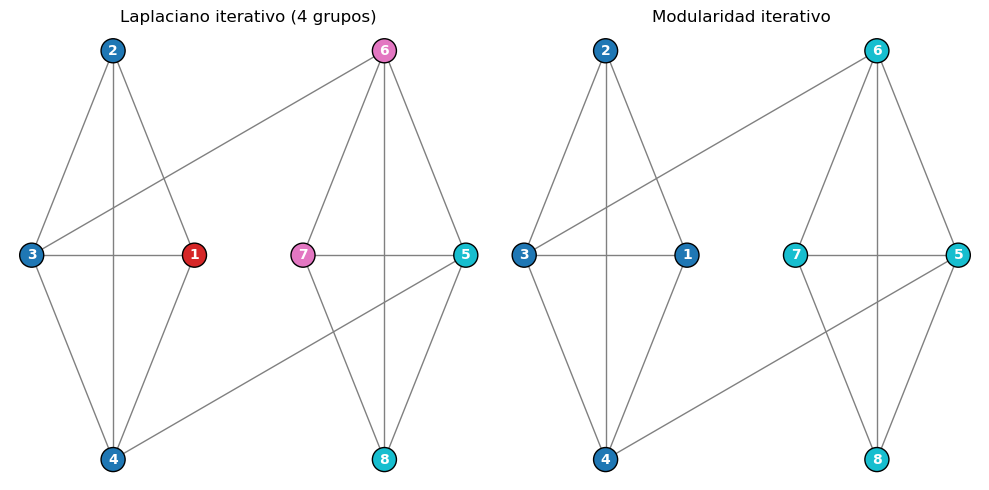

In [15]:
coms_L = laplaciano_iterativo(A_ejemplo, 2)

# comunidades por modularidad
coms_R = modularidad_iterativo(A_ejemplo)

print("Partición óptima en 4 grupos (Laplaciano):", coms_L)
print("Partición óptima modularidad:", coms_R)

# Asigna a cada nodo el índice de su comunidad
part_L = {}
for idx, comm in enumerate(coms_L):
    for node in comm:
        part_L[node] = idx

part_R = {}
for idx, comm in enumerate(coms_R):
    for node in comm:
        part_R[node] = idx

# Crea posiciones manuales: dos círculos, uno a la izquierda, otro a la derecha
pos = np.zeros((8,2))
# Nodos 0–3 en círculo centrado en (-1,0)
for i in range(4):
    angle = 2*np.pi*i/4
    pos[i] = [-1 + 0.6*np.cos(angle), 0 + 0.6*np.sin(angle)]
# Nodos 4–7 en círculo centrado en (1,0)
for i in range(4,8):
    angle = 2*np.pi*(i-4)/4
    pos[i] = [1 + 0.6*np.cos(angle), 0 + 0.6*np.sin(angle)]

# Función para dibujar un grafo dado un mapa de comunidad
def plot_partition(ax, A, pos, partition, title):
    # Dibuja aristas
    n = A.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            if A[i,j]:
                xi, yi = pos[i]
                xj, yj = pos[j]
                ax.plot([xi, xj], [yi, yj], color='gray', lw=1, zorder=1)
    # Dibuja nodos
    colors = [partition[i] for i in range(n)]
    xs = pos[:,0]; ys = pos[:,1]
    sc = ax.scatter(xs, ys, c=colors, s=300, cmap='tab10', edgecolors='k', zorder=2)
    # Etiquetas
    for i,(x,y) in enumerate(pos):
        ax.text(x, y, str(i+1), ha='center', va='center', color='white', weight='bold')
    ax.set_title(title)
    ax.axis('off')

# Ploteo en dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
plot_partition(ax1, A_ejemplo, pos, part_L, "Laplaciano iterativo (4 grupos)")
plot_partition(ax2, A_ejemplo, pos, part_R, "Modularidad iterativo")
plt.tight_layout()
plt.show()


### CONCLUSION 3:
La diferencia más grande está en el objetivo que busca cada método:

- El Laplaciano se concentra en hacer el "mejor corte" posible en cada paso para dividir la red. No tiene una regla propia para saber cuándo detenerse, por lo que es ideal si ya sabes de antemano en cuántos grupos quieres dividir todo.

- La Modularidad, en cambio, busca que la división final tenga el mejor "puntaje de calidad" posible. Intenta encontrar los grupos donde los miembros están muy conectados entre sí y para por sí sola cuando encuentra la división que tiene más sentido.

En resumen, para nuestra red de ejemplo, la Modularidad encontró la división más lógica en dos grandes grupos. El Laplaciano, como lo forzamos a seguir cortando, terminó creando una división más detallada (en cuatro pedazos más pequeños). Ninguno de los dos es mejor que el otro en todos los casos; el que conviene usar depende de lo que estés buscando lograr.

## Punto 4

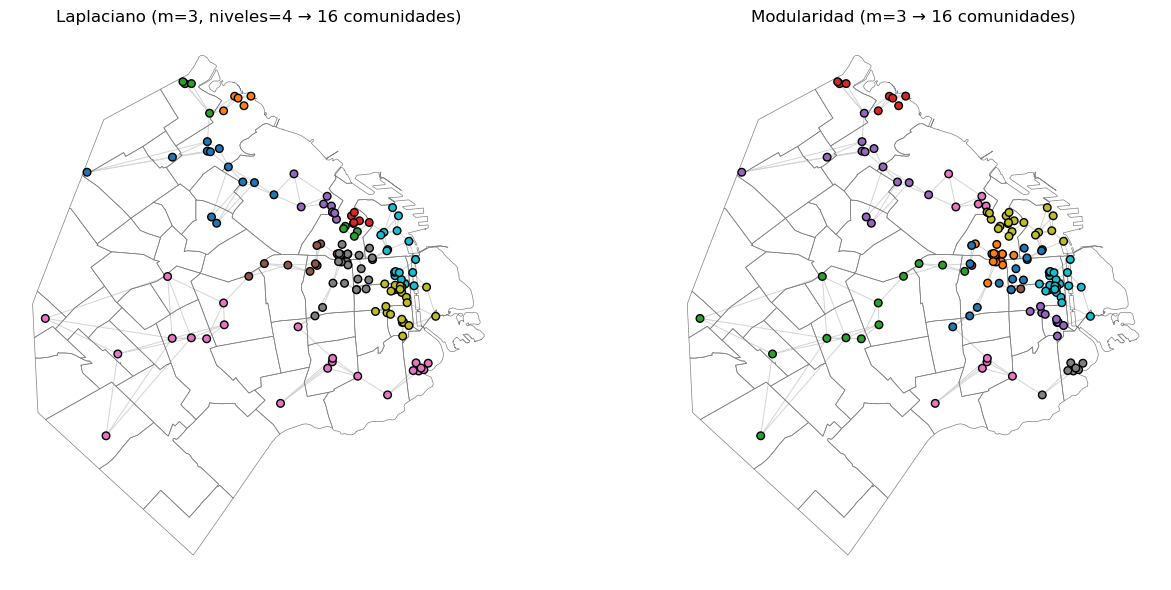


==== m = 3 ====
Laplaciano (niveles=4) → 16 comunidades:
  Grupo 1: ["Museo de Arte Español 'Enrique Larreta'", 'Museo Histórico de Buenos Aires Cornelio de Saavedra', 'Museo Casa de Yrurtia', 'Museo Histórico Sarmiento', 'Museo Ana Frank', 'Museo Líbero Badií']
  Grupo 2: ['Museo Profesor Miguel Ángel Fernández', 'Museo Nacional del Hombre', 'Museo Anconetani Del Acordeón - Musa', 'Museo Fotográfico Simik', "Museo Histórico del Regimiento Granaderos a Caballo 'General San Martín'", 'Museo de los Patricios de Buenos Ayres']
  Grupo 3: ['Museo River Plate', 'Monumento a las Víctimas del Terrorismo de Estado', 'Museo de Maquetas FADU-UBA', "Museo de Mineralogía 'Dra. Elmira Inés Mórtola'", 'Museo de matemática Mateuba']
  Grupo 4: ["Sitio de Memoria 'Casino de Oficiales - ESMA'", 'Museo Malvinas e Islas del Atlántico Sur', 'Museo archivo tecno educativo Lorenzo Raggio', 'Museo del Tiro Federal Argentino']
  Grupo 5: ['Museo Roca', 'Claustros históricos Basílica del Pilar', "Museo Notari

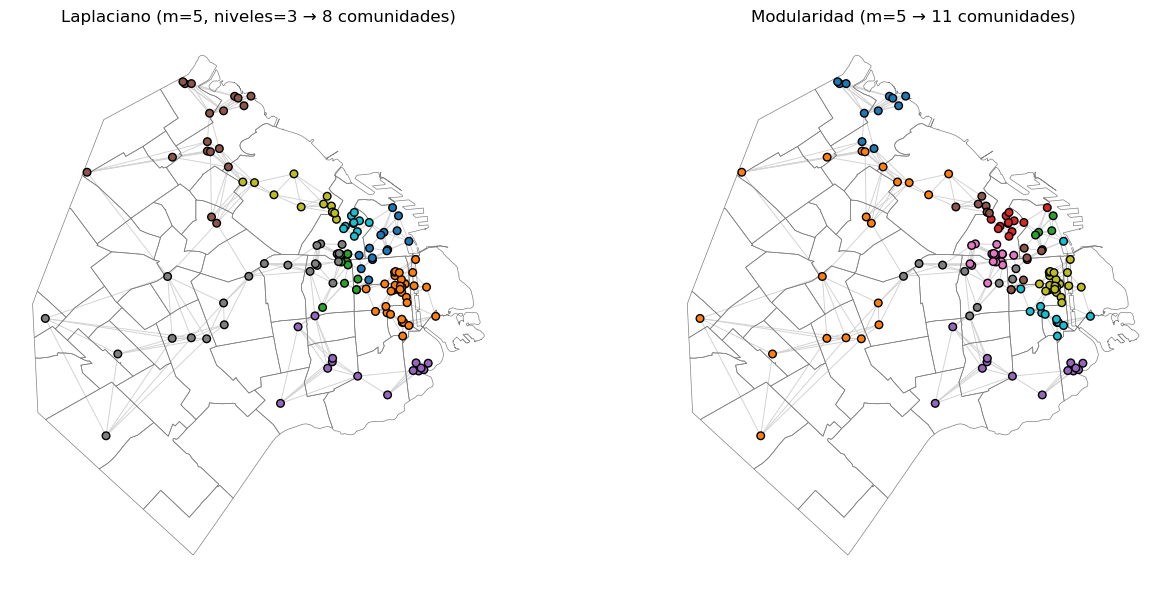


==== m = 5 ====
Laplaciano (niveles=3) → 8 comunidades:
  Grupo 1: ['Museo Nacional Ferroviario', 'Museo de Arte Hispanoamericano', 'Museo del Holocausto', 'Museo de Armas de la Nación', 'Museo Judío de Buenos Aires', 'Museo de la Inmigración', 'Museo de la Mujer', 'Museo de Informática', 'Museo Regina Pacini de Alvear', 'Museo de la Casa de Moneda', 'Instituto Nacional de Estudios De Teatro', "Museo Sadaic 'Vicente López y Planes'", 'Museo Histórico de la Gendarmería Nacional', 'Museo Iser']
  Grupo 2: ['Manzana de las Luces', 'Museo del Banco Central', "Colección de Arte 'Amalia Lacroze de Fortabat'", 'Museo Histórico Nacional', 'Museo del Humor', 'Museo de La Cárcova', 'Buque Museo Corbeta A.R.A. Uruguay', "Buque Museo Fragata A.R.A. 'Presidente Sarmiento'", 'Museo Casa Rosada', 'Museo Mitre', 'Museo de la Ciudad', 'Museo de Arte Moderno de Buenos Aires', 'Museo de la Santa Casa de Ejercicios Espirituales Sor María Antonia de la Paz y Figueroa', 'Museo de Arte Contemporáneo de Buen

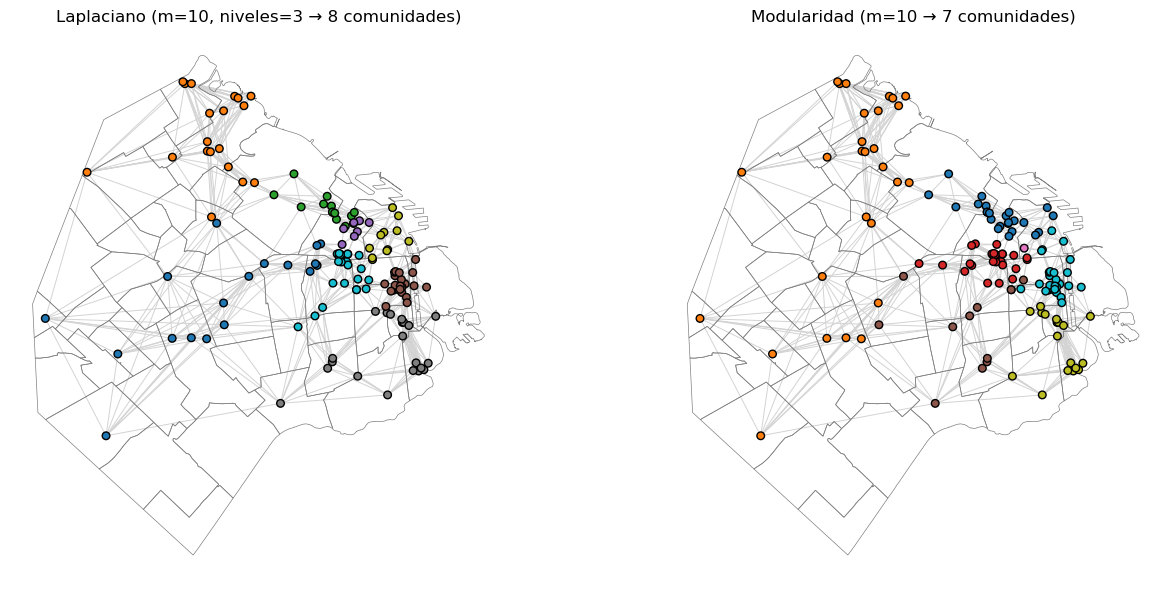


==== m = 10 ====
Laplaciano (niveles=3) → 8 comunidades:
  Grupo 1: ['Museo Argentino de Ciencias Naturales', 'Museo Casa Carlos Gardel', 'Museo de Esculturas Luis Perlotti', 'Museo del Automóvil', 'Museo Casa de Ricardo Rojas', 'Museo Anconetani Del Acordeón - Musa', 'Museo Criollo de los Corrales', 'Museo Casa de Batato Barea', 'Museo el templo del fútbol', 'Museo Barrio de Flores', 'Museo Xul Solar', 'Museo Kosice', 'Museo le los Niños Abasto', 'Museo Etnográfico de las Obras Misionales Pontificias', 'Museo de la anestesia y biblioteca histórica de la AAARBA', 'Museo General Belgrano', "Escuela Museo de Bellas Artes 'General Urquiza'", 'Museo Histórico Vecinal de Flores']
  Grupo 2: ["Museo de Arte Español 'Enrique Larreta'", 'Museo River Plate', "Sitio de Memoria 'Casino de Oficiales - ESMA'", 'Museo Histórico de Buenos Aires Cornelio de Saavedra', 'Museo Malvinas e Islas del Atlántico Sur', 'Museo Casa de Yrurtia', 'Museo Histórico Sarmiento', 'Monumento a las Víctimas del Terro

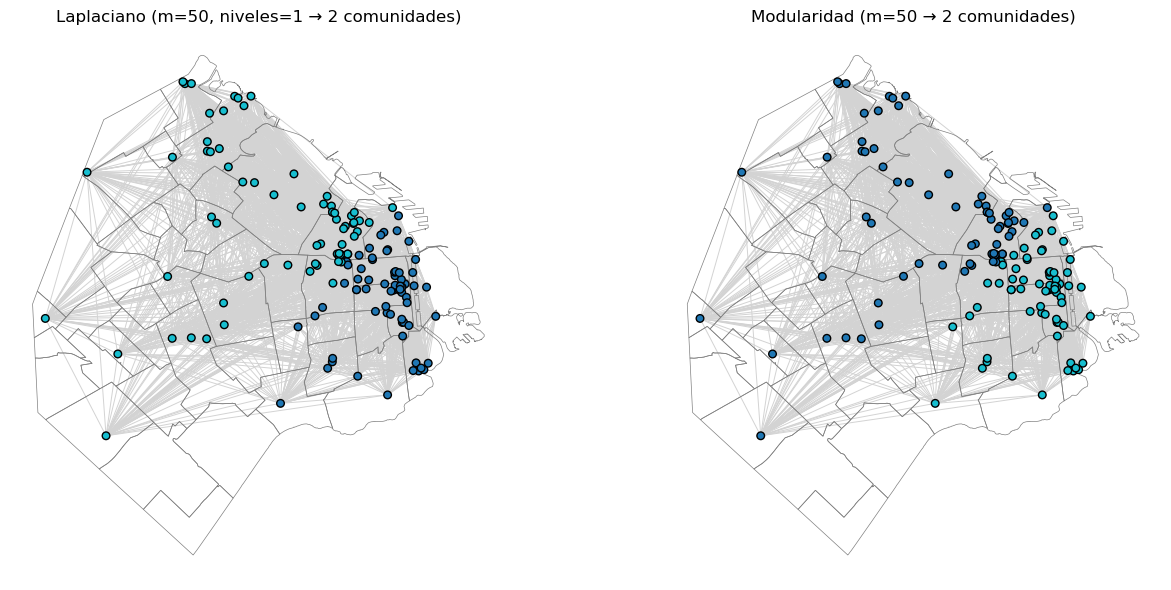


==== m = 50 ====
Laplaciano (niveles=1) → 2 comunidades:
  Grupo 1: ['Manzana de las Luces', 'Museo del Banco Central', "Colección de Arte 'Amalia Lacroze de Fortabat'", 'Museo Histórico Nacional', 'Museo del Humor', 'Museo de La Cárcova', 'Buque Museo Corbeta A.R.A. Uruguay', "Buque Museo Fragata A.R.A. 'Presidente Sarmiento'", 'Museo Casa Rosada', 'Museo Mitre', 'Museo de la Ciudad', 'Museo de Arte Moderno de Buenos Aires', 'Museo Nacional Ferroviario', 'Museo de los Corrales Viejos', 'Museo de la Santa Casa de Ejercicios Espirituales Sor María Antonia de la Paz y Figueroa', 'Museo de Arte Contemporáneo de Buenos Aires', 'Museo de Arte Hispanoamericano', 'Museo Histórico Nacional del Cabildo y de la Revolución de Mayo', 'Museo del Holocausto', 'Museo de Armas de la Nación', 'Museo de la Pasión Boquense', "Museo de la Psicología Experimental en Argentina 'Dr. Horacio G. Piñero'", 'Museo Argentino del Títere', 'Museo de la Emigración Gallega en la Argentina', 'Museo Judío de Buenos Ai

In [16]:
m_values = [3, 5, 10, 50]
results = {}
coords = np.array([(p.x, p.y) for p in museos.geometry])
for m in m_values:
    A = construye_adyacencia(D, m)
    A_sym = np.ceil((A + A.T)/2).astype(int)
    mod_comms = modularidad_iterativo(A_sym)
    k_mod = len(mod_comms)

    # buscar nivel de Laplaciano que iguale número de comunidades
    best_lvl, best_lap = None, None
    diff_min = np.inf
    for lvl in [1,2,3,4]:
        lap_comms = laplaciano_iterativo(A_sym, niveles=lvl)
        d = abs(len(lap_comms) - k_mod)
        if d < diff_min:
            diff_min, best_lvl, best_lap = d, lvl, lap_comms

    results[m] = (A_sym, best_lvl, best_lap, mod_comms)

# ——— Visualización sin NetworkX ———
for m, (A_sym, lvl, lap_comms, mod_comms) in results.items():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    for ax, comms, title in zip(axes, [lap_comms, mod_comms], ['Laplaciano', 'Modularidad']):
        barrios.boundary.plot(color='gray', ax=ax, linewidth=0.5)

        # dibujar aristas manualmente
        n = A_sym.shape[0]
        for i in range(n):
            for j in range(i+1, n):
                if A_sym[i, j]:
                    xs = [coords[i, 0], coords[j, 0]]
                    ys = [coords[i, 1], coords[j, 1]]
                    ax.plot(xs, ys, color='lightgray', linewidth=0.7, zorder=1)

        # colorear nodos según comunidad
        labels = np.zeros(n, dtype=int)
        for idx, grupo in enumerate(comms):
            for node in grupo:
                labels[node] = idx
        ax.scatter(coords[:, 0], coords[:, 1],
                   c=labels, cmap='tab10',
                   s=30, edgecolor='k', zorder=2)

        subtitle = f"m={m}"
        if title == 'Laplaciano':
            subtitle += f", niveles={lvl}"
        subtitle += f" → {len(comms)} comunidades"
        ax.set_title(f"{title} ({subtitle})")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # ——— Listado de grupos en texto ———
    print(f"\n==== m = {m} ====")
    print(f"Laplaciano (niveles={lvl}) → {len(lap_comms)} comunidades:")
    for i, grp in enumerate(lap_comms, 1):
        nombres = museos.iloc[list(grp)]['name'].tolist()
        print(f"  Grupo {i}: {nombres}")
    print(f"\nModularidad → {len(mod_comms)} comunidades:")
    for i, grp in enumerate(mod_comms, 1):
        nombres = museos.iloc[list(grp)]['name'].tolist()
        print(f"  Grupo {i}: {nombres}")
    print("\n" + "-"*60 + "\n")

### CONCLUSION 4:
Lo que se puede ver es que mientras mas pequeña es el m, mas grupos se generan, lo cual tiene sentido ya que el m indica la cantidad de aristas que salen de un nodo. Vemos que con m=3 o m=5, los grupos que se forman marcan los barrios de la cuidad. Cuando aumentamos a m=10 vemos como esas grupos se fusionan, donde se marcan las regiones de la cuidad. Ya para m=50 se forma un grupo solo que tiene sentido por la cantidad de conexiones.

## Síntesis Final: Análisis Integrado de la Red de Museos

### 1. Integración TP1-TP2  
El TP1 nos permitió entender qué museos son más importantes usando PageRank. Museos como el de Farmacobotánica, el de Odontología y el Museo de la Ciudad aparecieron como los más influyentes, manteniéndose en el top 3 sin importar el valor de *m*. Estos museos actúan como nodos clave de la red, atrayendo visitas y conectando distintas zonas.

El TP2 llevó esta idea más allá: mostró cómo se agrupan los museos entre sí, y confirmó que estos nodos centrales también son los que ayudan a unir distintas comunidades. Con redes menos conectadas (*m = 3*), se forman grupos por cercanía (como en San Telmo o Recoleta); con redes más densas (*m = 10*), aparecen comunidades que agrupan museos por temas, incluso si están lejos entre sí.

### 2. Comparación de Métodos  
- **Laplaciano:** Es nuestro detector de barrios. Con *m = 3* o *5*, detecta bien grupos por zonas, como los museos del norte o del sur. Es útil si queremos planear rutas turísticas caminables.  
- **Modularidad:** Es nuestro buscador de afinidades temáticas o funcionales entre instituciones. Con *m = 5*, forma comunidades más chicas y más repartidas, donde museos con contenidos similares (como ciencia o arte) se agrupan aunque estén lejos. Ideal para armar circuitos temáticos.  

**Conclusión:** el Laplaciano nos dice *dónde están juntos*, y la Modularidad nos dice *por qué están juntos*.

### 3. Interpretación Cultural y Cambios con los Parámetros  
El parámetro *m* (número de conexiones) tiene un impacto fuerte. Con *m* bajo, la red se fragmenta en barrios con identidades marcadas. Con *m* alto, las conexiones aumentan y los grupos se arman por temas, no por ubicación.

Además, también influye el parámetro *α* del PageRank:  
- Con *α = 0.86*, un museo domina la red.  
- Con *α = 0.14*, la importancia se reparte más parejo entre todos.  

Esto muestra cómo algunos museos tienen una centralidad estable, mientras otros dependen más de cómo está armada la red.

### 4. Conclusiones y Aprendizajes  
- **Museos centrales constantes:** Farmacobotánica, Odontología y el Museo de la Ciudad se repiten siempre en el centro de la red. Son como “instituciones ancla” que mantienen la cohesión de la red.  
- **Los parámetros afectan diferente:** *m* cambia la forma de la red pero no el ranking, mientras que *α* sí puede redistribuir el peso entre los museos.  
- **Los métodos se complementan:** Laplaciano ayuda a ver la estructura geográfica, Modularidad detecta afinidades temáticas.  
- **Los dos TPs se confirman entre sí:** Los museos con alto PageRank también resultaron ser conectores clave entre comunidades.

### 5. Proyecciones y Mejoras Posibles  
- Algunas métricas podrían subestimar museos importantes si sólo se basan en distancia euclideas (dado por el dataset).   
- Estos resultados pueden servir para planificar actividades culturales: reforzar los museos "mas visitados o con mas conexiones" y diseñar circuitos temáticos o barriales según la estructura de la red.